In [1]:

import pandas as pd
import os
import os.path
import matplotlib.pyplot as plt

full_file_path = os.path.join(os.getcwd(),"rlog1.csv")
df = pd.read_csv(full_file_path, encoding="ISO-8859-1", na_values=['NA','?'])

pd.set_option('display.max_columns', 11) 
pd.set_option('display.max_rows', 5)
print(df.shape)
display(df)

(6193, 14)


,ORG,COMPSS,PITCH,ROLL,CLIFF,...,LASTRHT,LFTAVG,RHTAVG,DTURN,DDIR
0,000,15,-1168,176,81,...,23134,0,0,0,FWD
1,101,201,-1200,160,72,...,23225,0,0,527,SLF
...,...,...,...,...,...,...,...,...,...,...,...
6191,001,221,-640,6336,82,...,14746,3447,4201,658,0RT
6192,000,173,-2272,3248,92,...,15915,3477,4201,0,FWD


In [2]:
print("Filtered column indexes to lower: ")
df.columns = [x.lower() for x in df.columns]
for c in df.columns:
    print(c)

Filtered column indexes to lower: 
org
compss
pitch
roll
cliff
lft
ctr
rht
lastlft
lastrht
lftavg
rhtavg
dturn
ddir


In [3]:
# Count Categorical data input 
# This data needs some explanation
#   000 no sensors hit
#   001 sensor hit on the right
#   100 sensor hit on the left
#   010 sensor hit in the middle
#   110 sensor hit on left and middle 
#   011 sensor hit on right and middle
#   101 sensor hit on left and right
#   111 all sensors hit
#   TOF same as CLIFF this sensor detects if the ground is present 
#         it is an edge detection to prevent robot from going down stairs
#   CTG Clear To Go this means the robot has not hit a sensor
#         for quite some time, this causes the robot to randomly turn
#        
scolumn = "org"                 # org - original hit
nunique = df[scolumn].nunique()
vcounts = pd.value_counts(df[scolumn])
print("Unique codes for column: " + scolumn + " : ", nunique)
print("Code  Count")
pd.set_option('display.max_rows', 15)
print(vcounts)

Unique codes for column: org :  10
Code  Count
000    2706
001    1323
100     988
CTG     466
010     365
011     126
TOF      77
101      69
111      37
110      36
Name: org, dtype: int64


In [4]:

# when robot starts averages are 0 zero
# fill them with the mean value
leftmean = df['lftavg'].mean()
rightmean = df['rhtavg'].mean()
df['lftavg'] = df['lftavg'].replace(0, leftmean)
df['rhtavg'] = df['rhtavg'].replace(0, rightmean)
print(leftmean, rightmean)

3507.135314064266 3210.166478281931


In [5]:
# Create dummies for Categorical input original hit - org
dummies = pd.get_dummies(df['org'],prefix="in")
print(dummies)

      in_000  in_001  in_010  in_011  in_100  in_101  in_110  in_111  in_CTG  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       1       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          0       0       0       0       0       0       0       0       0   
4          1       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
6188       1       0       0       0       0       0       0       0       0   
6189       0       1       0       0       0       0       0       0       0   
6190       1       0       0       0       0       0       0       0       0   
6191       0       1       0       0       0       0       0       0       0   
6192       1       0       0       0       0       0       0       0       0   

      in_TOF  
0          0  
1        

In [6]:
# preserve original dataframe for testing
df2 = pd.concat([df,dummies],axis=1)  # concat dummies 
df2.drop('org', axis=1, inplace=True) # original hit
# drop dturn 'decision turn' this is a turn delay time 
#   it a random number between range(300-1000)
#   computed after turn type
df2.drop('dturn',axis=1,inplace=True) 
print(list(df2.columns))

['compss', 'pitch', 'roll', 'cliff', 'lft', 'ctr', 'rht', 'lastlft', 'lastrht', 'lftavg', 'rhtavg', 'ddir', 'in_000', 'in_001', 'in_010', 'in_011', 'in_100', 'in_101', 'in_110', 'in_111', 'in_CTG', 'in_TOF']


In [7]:

from scipy.stats import zscore

df2['compss'] = zscore(df2['compss'])   # compass heading in degrees 0-360
df2['pitch'] = zscore(df2['pitch'])     # pitch 
df2['roll'] = zscore(df2['roll'])       # roll
df2['cliff'] = zscore(df2['cliff'])     # edge detector alerts when ground is not sensed
df2['lft'] = zscore(df2['lft'])         # infrared sensor left
df2['ctr'] = zscore(df2['ctr'])         # ultrasonic sensor center
df2['rht'] = zscore(df2['rht'])         # infrared sensor right
df2['lastlft'] = zscore(df2['lastlft']) # time stamp - time since last hit
df2['lastrht'] = zscore(df2['lastrht']) # time stamp - time since last hit
df2['lftavg'] = zscore(df2['lftavg'])   # average of the last 20 hits
df2['rhtavg'] = zscore(df2['rhtavg'])   # average of the last 20 hits

# ddir or 'decision direction' is what we are trying to predict
#          also called turntype
x_columns = df2.columns.drop('ddir') 
x = df2[x_columns].values
print(x_columns)

# turntype or 'decision direction' is what we are trying to Classify
dummies = pd.get_dummies(df2['ddir']) 
turntype = dummies.columns
print(turntype)
y = dummies.values


Index(['compss', 'pitch', 'roll', 'cliff', 'lft', 'ctr', 'rht', 'lastlft',
       'lastrht', 'lftavg', 'rhtavg', 'in_000', 'in_001', 'in_010', 'in_011',
       'in_100', 'in_101', 'in_110', 'in_111', 'in_CTG', 'in_TOF'],
      dtype='object')
Index(['0LF', '0RT', '1LF', '1RT', 'ALF', 'ART', 'CCT', 'CLF', 'CRT', 'FWD',
       'SLF'],
      dtype='object')


In [8]:
# Classification neural network
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(100, input_dim=x.shape[1], activation='relu',
                kernel_initializer='random_normal'))
model.add(tf.keras.layers.Dense(50,activation='relu',kernel_initializer='random_normal'))
model.add(tf.keras.layers.Dense(25,activation='relu',kernel_initializer='random_normal'))
model.add(tf.keras.layers.Dense(y.shape[1],activation='softmax',
                kernel_initializer='random_normal'))
model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics =['accuracy'])
monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                        verbose=1, mode='auto', restore_best_weights=True)
modelHistory = model.fit(x_train,y_train,validation_data=(x_test,y_test),
          callbacks=[monitor],verbose=2,epochs=1000)

Epoch 1/1000
146/146 - 2s - loss: 1.4814 - accuracy: 0.5273 - val_loss: 0.8034 - val_accuracy: 0.6985 - 2s/epoch - 11ms/step
Epoch 2/1000
146/146 - 0s - loss: 0.5901 - accuracy: 0.7537 - val_loss: 0.4934 - val_accuracy: 0.8089 - 319ms/epoch - 2ms/step
Epoch 3/1000
146/146 - 0s - loss: 0.4053 - accuracy: 0.8363 - val_loss: 0.3385 - val_accuracy: 0.8618 - 386ms/epoch - 3ms/step
Epoch 4/1000
146/146 - 0s - loss: 0.3172 - accuracy: 0.8650 - val_loss: 0.2825 - val_accuracy: 0.8832 - 364ms/epoch - 2ms/step
Epoch 5/1000
146/146 - 0s - loss: 0.2748 - accuracy: 0.8829 - val_loss: 0.2511 - val_accuracy: 0.8954 - 307ms/epoch - 2ms/step
Epoch 6/1000
146/146 - 0s - loss: 0.2291 - accuracy: 0.9018 - val_loss: 0.2096 - val_accuracy: 0.9180 - 360ms/epoch - 2ms/step
Epoch 7/1000
146/146 - 0s - loss: 0.2052 - accuracy: 0.9190 - val_loss: 0.2038 - val_accuracy: 0.9012 - 346ms/epoch - 2ms/step
Epoch 8/1000
146/146 - 0s - loss: 0.1856 - accuracy: 0.9210 - val_loss: 0.1821 - val_accuracy: 0.9225 - 349ms/epo

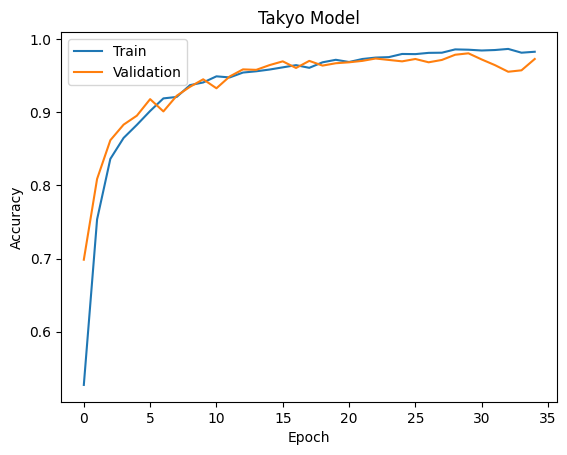

In [10]:
#from tf.keras.callbacks import History
def plotGraph(history: tf.keras.callbacks.History, modelName = 'Model Accuracy'):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(modelName)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train','Validation'], loc='upper left')
  plt.show()
plotGraph(modelHistory,"Takyo Model")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("TakyoModel.tflite", "wb") as f:
  f.write(tflite_model)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2200      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 11)                286       
                                                                 
Total params: 8,811
Trainable params: 8,811
Non-trainable params: 0
_________________________________________________________________


In [12]:
import numpy as np
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1) 
# raw probabilities to chosen class (highest probability)
from sklearn import metrics

y_compare = np.argmax(y_test,axis=1) 
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))

49/49 [==============================] - 0s 1ms/step
Accuracy score: 0.9806326662362814


In [13]:
from IPython.display import display

# Don't display numpy in scientific notation
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# Generate predictions
pred = model.predict(x_test)

print("Numpy array of predictions")
display(pred[0:5])

print("As percent probability")
print(pred[0]*100)

score = metrics.log_loss(y_test, pred)
print("Log loss score: {}".format(score))

# raw probabilities to chosen class (highest probability)
pred = np.argmax(pred,axis=1) 

49/49 [==============================] - 0s 1ms/step
Numpy array of predictions


array([[0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 1.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 1.    , 0.    ],
       [0.9989, 0.0011, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 1.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.0008, 0.9992, 0.    ]], dtype=float32)

As percent probability
[  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]
Log loss score: 0.06702232282597514


Normalized confusion matrix
[[0.95 0.05 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.99 0.   0.01 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.99 0.   0.01 0.   0.   0.   0.   0.  ]
 [0.   0.02 0.02 0.96 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.88 0.12 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.08 0.77 0.   0.   0.15 0.  ]
 [0.   0.   0.   0.   0.   0.   0.93 0.07 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.04 0.96 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.06 0.06 0.89 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]
(10, 10)


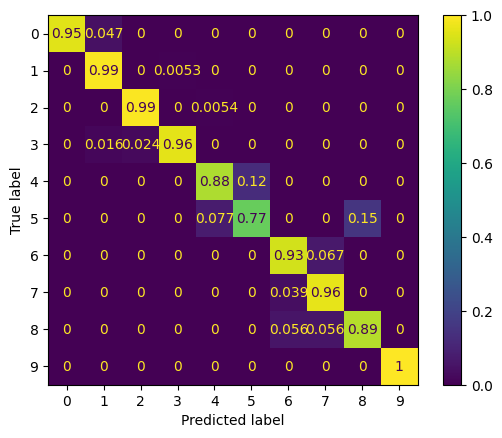

In [14]:

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Compute confusion matrix
cm = metrics.confusion_matrix(y_compare, pred)
np.set_printoptions(precision=2)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
print(cm_normalized.shape)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
cm_display.plot()
plt.show()